## Loading Files and Libraries

In [1]:
!wget 'https://docs.google.com/uc?export=download&id=1m3mUmcP5hlzJ14tv7uhXCSYuzq7jrnXX&confirm=t' -o data.zip

In [2]:
!ls

 data.zip
 sample_data
'uc?export=download&id=1m3mUmcP5hlzJ14tv7uhXCSYuzq7jrnXX&confirm=t'


In [3]:
!mv 'uc?export=download&id=1m3mUmcP5hlzJ14tv7uhXCSYuzq7jrnXX&confirm=t' 'data.zip'

In [4]:
!7z e data.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 412147486 bytes (394 MiB)

Extracting archive: data.zip
 31% 4096 Open              --
Path = data.zip
Type = zip
Physical Size = 412147486

  0%      1% 165 - summer_2022_project/audio/12741.wav                                                2% 380 - summer_2022_project/audio/9912.wav                                               4% 564 - summer_2022_project/audio/659.wav                                            

In [5]:
##-- IMPORTING LIBRARIES
import math

import librosa
import librosa.display

import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.utils import Bunch
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

import matplotlib.pyplot as plt

import torch
from torch.optim import SGD
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import SubsetRandomSampler, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision.models import resnet18
from torchvision.utils import make_grid
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, Lambda

from torchaudio import transforms

from IPython.display import clear_output

In [6]:
##-- LOADING TAGS
data = pd.read_csv('development.csv')
tags = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Suprised']
letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
data.head()

,emotion,filename
0,Disgusted,0.wav
1,Fearful,1.wav
2,Neutral,2.wav
3,Happy,3.wav
4,Angry,4.wav


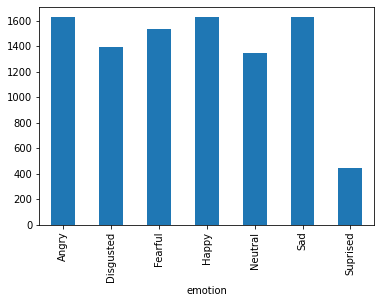

In [7]:
##-- EXPLORING TAG DISTRIBUTION
fig = data.groupby('emotion').count().plot.bar(legend=False)

In [8]:
##-- LOADING AUDIO
sample_rate = 22050
signals = []
path = ""
samples = np.random.choice(len(data), len(data), replace = False)
for i in range(len(data)):
    signal = None
    if i in samples:
        signal, sr = librosa.load(path + data.loc[i]["filename"])
    signals.append(signal)
data['signal'] = signals
data = data[data['signal'].notnull()]
data.head()

,emotion,filename,signal
0,Disgusted,0.wav,"[-0.0014322733, -0.0022769405, -0.002900324, -..."
1,Fearful,1.wav,"[0.0036420147, 0.006067276, 0.008132309, 0.009..."
2,Neutral,2.wav,"[-3.0601244e-05, -4.525978e-05, -5.6225515e-05..."
3,Happy,3.wav,"[-3.13682e-05, -3.7816084e-05, -3.5207177e-05,..."
4,Angry,4.wav,"[0.0023931498, 0.004058328, 0.005542969, 0.006..."


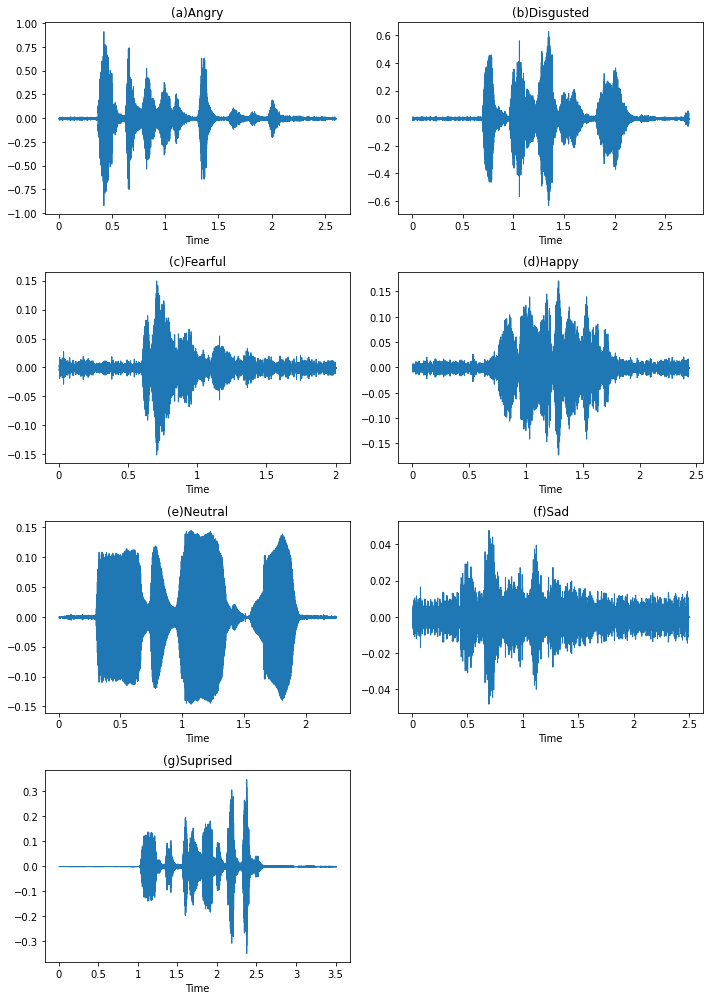

In [9]:
##-- PRINTING SAMPLE

fig, axs = plt.subplots(4,2)
fig.set_size_inches(10,14)
axs = axs.ravel()
for i in range(len(tags)):
   signal = data[data['emotion'] == tags[i]]['signal'].sample(1).to_numpy()[0]
   img = librosa.display.waveshow(signal, x_axis='time', ax=axs[i])
   axs[i].set_title(letters[i] + tags[i])

fig.delaxes(axs[7])
fig.tight_layout()

## Exploring Data

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


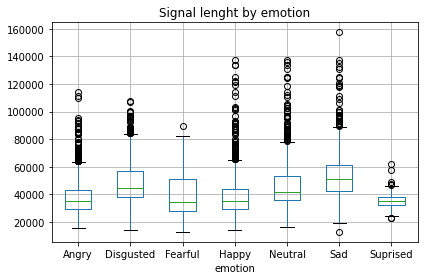

In [45]:
##-- EXPLORING LENGHT DISTRIBUTION
data["signal_length"] = data["signal"].apply(lambda x: len(x))
axs = data[data.signal_length > 0].boxplot(column="signal_length",by="emotion")
axs.set_title('Signal lenght by emotion')
fig = axs.get_figure()
fig.suptitle('')
data.drop('signal_length', axis=1)
plt.tight_layout()

## Preprocesing Audio

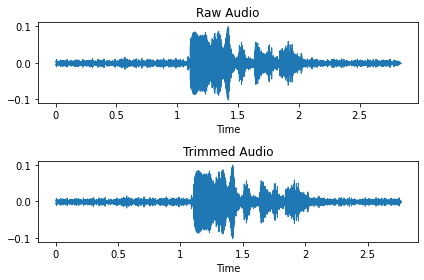

In [11]:
##-- TRIMMING SILENCE AUDIO
fig, axs = plt.subplots(2,1)
librosa.display.waveshow(data.loc[samples[80]]['signal'], ax=axs[0])
axs[0].set_title('Raw Audio')

data['signal'] = data['signal'].apply(lambda y: librosa.effects.trim(y, top_db=20)[0])
data['signal'] = data['signal'].apply(lambda y: librosa.effects.trim(y, top_db=20)[0])

librosa.display.waveshow(data.loc[samples[80]]['signal'], ax=axs[1])
axs[1].set_title('Trimmed Audio')
fig.tight_layout()


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


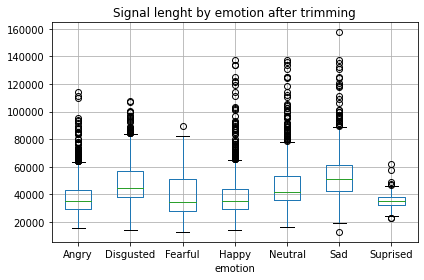

In [42]:
##-- EXPLORING LENGHT DISTRIBUTION AFTER TRIMMING
data["signal_length"] = data["signal"].apply(lambda x: len(x))
axs = data[data.signal_length > 0].boxplot(column="signal_length",by="emotion")
axs.set_title('Signal lenght by emotion after trimming')
fig = axs.get_figure()
fig.suptitle('')
data = data.drop('signal_length', axis=1)
plt.tight_layout()

In [13]:
#-- CONVERTING TO SPECTROGRAM
spec_width = 224
data['spec'] = data['signal'].apply(lambda y: librosa.feature.melspectrogram(y = y, hop_length = math.floor(len(y)/spec_width), n_mels=spec_width))
data['spec'] = data['spec'].apply(lambda y: librosa.amplitude_to_db(y))
data['spec'] = data['spec'].apply(lambda y: np.delete(y, np.s_[spec_width:y.shape[1]], 1))

#data['mfcc'] = data['signal'].apply(lambda y: transforms.MFCC(n_mfcc=128, melkwargs = {'hop_length':hop_len})(torch.Tensor(y)))
#data['chroma'] = data['signal'].apply(lambda y: torch.Tensor(librosa.feature.chroma_stft(y, hop_length=hop_len)))

(224, 224)


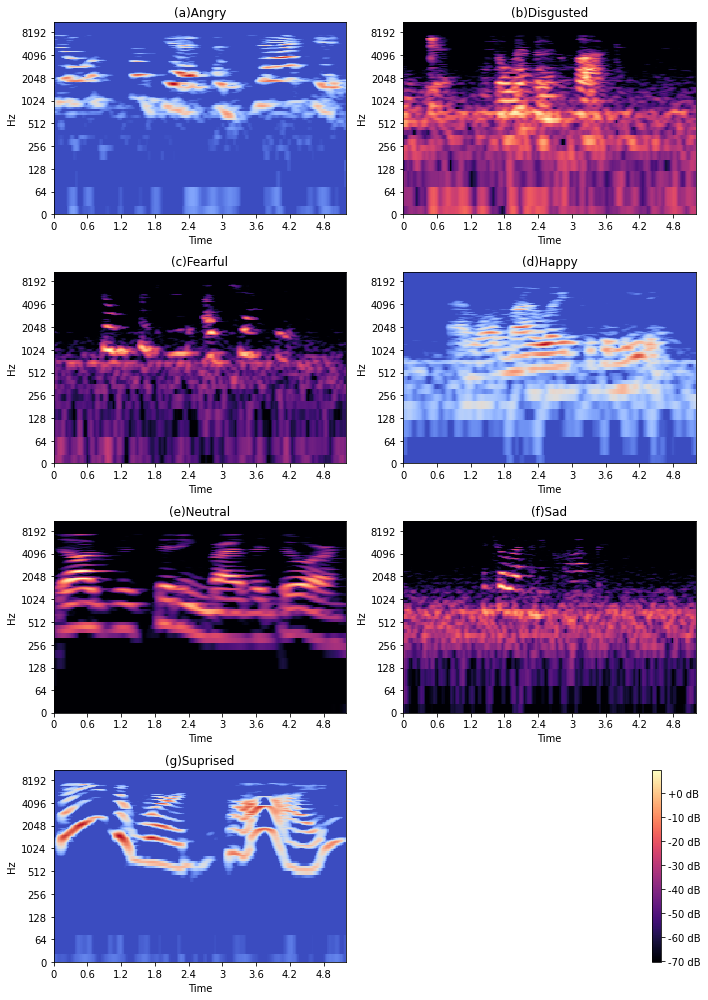

In [14]:
#-- PRINTING SPECTOGRAMS
fig, axs = plt.subplots(4,2)
fig.set_size_inches(10,14)
axs = axs.ravel()
for i in range(len(tags)):
   spec = data[data['emotion'] == tags[i]]['spec'].sample(1).to_numpy()[0]
   img = librosa.display.specshow(spec, x_axis='time', y_axis='log', ax=axs[i])
   axs[i].set_title(letters[i] + tags[i])
   if i == 4:
      fig.colorbar(img, format='%+2.0f dB')
      print(spec.shape)

fig.delaxes(axs[7])
fig.tight_layout()

In [15]:
##-- ENCODING TAGS
int_encoder = LabelEncoder()
encoder = OneHotEncoder()

data['y'] = data['emotion'].apply(lambda tag: tags.index(tag))
data.head()

,emotion,filename,signal,spec,y
0,Disgusted,0.wav,"[3.230921e-05, -0.0031049857, -0.006707782, -0...","[[-34.073162, -34.073162, -34.073162, -33.5190...",1
1,Fearful,1.wav,"[0.0036420147, 0.006067276, 0.008132309, 0.009...","[[-49.451614, -37.31143, -28.29337, -25.144423...",2
2,Neutral,2.wav,"[0.0002796986, -0.00043701258, -0.001463944, -...","[[-50.03103, -50.03103, -50.03103, -50.03103, ...",4
3,Happy,3.wav,"[-3.3131294e-06, 0.0003148059, 0.0005223764, 0...","[[-56.40022, -56.40022, -56.40022, -56.40022, ...",3
4,Angry,4.wav,"[0.0070324223, 0.0068252473, 0.0061777355, 0.0...","[[-6.1526413, -6.1526413, -6.1526413, -6.15264...",0


## Processing the audio (SVM)

In [16]:
##-- AVERAGING THE SPECTROGRAM
data_svm = data
data_svm['spec_avg'] = data['spec'].apply(lambda y: np.average(y, axis=1))
data.head()

,emotion,filename,signal,spec,y,spec_avg
0,Disgusted,0.wav,"[3.230921e-05, -0.0031049857, -0.006707782, -0...","[[-34.073162, -34.073162, -34.073162, -33.5190...",1,"[-22.925337, -22.223764, -30.853756, -33.27189..."
1,Fearful,1.wav,"[0.0036420147, 0.006067276, 0.008132309, 0.009...","[[-49.451614, -37.31143, -28.29337, -25.144423...",2,"[-24.074446, -22.53161, -30.350895, -28.854923..."
2,Neutral,2.wav,"[0.0002796986, -0.00043701258, -0.001463944, -...","[[-50.03103, -50.03103, -50.03103, -50.03103, ...",4,"[-50.03103, -50.03103, -50.03103, -49.756714, ..."
3,Happy,3.wav,"[-3.3131294e-06, 0.0003148059, 0.0005223764, 0...","[[-56.40022, -56.40022, -56.40022, -56.40022, ...",3,"[-51.030315, -54.780613, -56.201416, -56.40021..."
4,Angry,4.wav,"[0.0070324223, 0.0068252473, 0.0061777355, 0.0...","[[-6.1526413, -6.1526413, -6.1526413, -6.15264...",0,"[-6.1254077, -6.1526413, -6.1526413, -6.152641..."


In [17]:
##-- ENCODING ARRAY AND STANDARD SCALER
scaler = StandardScaler()
data_matrix = scaler.fit_transform(np.stack(data_svm['spec_avg'].to_numpy(), axis = 0))

bunch = Bunch(data=data_matrix,
                 target=data_svm['y'].to_numpy(),
                 target_names=data_svm['emotion'].to_numpy())

In [18]:
X_train, X_test, y_train, y_test = train_test_split(bunch.data, bunch.target, test_size=0.2, random_state=42)

print(bunch.target.shape)

params = {
    'C':[0.001, 0.01, 1, 5, 10, 25],
    'kernel':['poly', 'rbf']
}

clf = svm.SVC()
gs_clf = GridSearchCV(clf, params, n_jobs=-1, scoring='f1_macro')
gs_clf.fit(X_train, y_train)
prediction = gs_clf.predict(X_test)
print(type(clf))
print(classification_report(prediction, y_test))
print(gs_clf.best_params_)

(9597,)
<class 'sklearn.svm._classes.SVC'>
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       353
           1       0.53      0.56      0.54       290
           2       0.40      0.60      0.48       198
           3       0.53      0.58      0.56       289
           4       0.63      0.53      0.57       328
           5       0.71      0.59      0.64       378
           6       0.71      0.77      0.74        84

    accuracy                           0.60      1920
   macro avg       0.61      0.62      0.61      1920
weighted avg       0.62      0.60      0.60      1920

{'C': 25, 'kernel': 'rbf'}


## Processing the audio (1D-NN)

In [19]:
#-- DEFINING TRAINING LOOP
def train(dataloader, model, loss_fn, optm, epoch):
    train_loss=0.0
    model.train() # train mode
    model.to(torch.device(device)) # send it to device
    pred_vals = []
    actual_vals = []
    for X,y in dataloader:
        X = X.to(torch.device(device))
        y = y.to(torch.device(device))
        optm.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optm.step()
        train_loss += loss.item() * X.size(0)
        actual_vals.extend(y.numpy())
        pred_vals.extend(torch.max(pred, 1)[1].numpy())
        del loss, pred, X, y

    return train_loss, pred_vals, actual_vals

In [20]:
#-- DEFINING TEST LOOP
def test(dataloader, model, epoch):
    test_loss=0.0
    model.eval()
    model.to(torch.device(device)) # send it to device
    pred_vals = []
    actual_vals = []
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(torch.device(device))
            y = y.to(torch.device(device))
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item() * X.size(0)
            actual_vals.extend(y.numpy())
            pred_vals.extend(torch.max(pred, 1)[1].numpy())
            del loss, pred, X, y
            
        return test_loss, pred_vals, actual_vals

In [21]:
##-- DESINGNING NET
class AudioNet(nn.Module):
    def __init__(self, num_classes=7, in_features=None):
        super(AudioNet, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(in_features, out_features=in_features),
            nn.ReLU(inplace=True),
            nn.Linear(in_features, out_features=in_features),
            nn.ReLU(inplace=True),
            nn.Linear(in_features, out_features=in_features),
            nn.ReLU(inplace=True),
            nn.Linear(in_features, out_features=in_features),
            nn.ReLU(inplace=True),
            nn.Linear(in_features, out_features=in_features),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(in_features, in_features),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [22]:
#-- DEFINING HYPERPARAMS, MODEL, LOSS AND OPTIMIZER
learning_rate = 1e-3
epochs = 60
batch = 128
model = AudioNet(num_classes=7, in_features=bunch.data.shape[1])
optm = SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

if torch.cuda.is_available():  
  device = "cuda:0"
else:  
  device = "cpu"

In [23]:
#-- TRAINING THE NET

idxs = np.array(range(0,len(data)))
X_train, X_test, _, _ = train_test_split(idxs, data['y'].to_numpy(), test_size=0.20, random_state=42)

history = {'train_loss': [], 'train_f1': [], 'test_loss': [], 'test_f1': []}

spec = torch.from_numpy(bunch.data)

dataset = TensorDataset(spec, torch.from_numpy(bunch.target))
train_sampler = SubsetRandomSampler(X_train)
test_sampler = SubsetRandomSampler(X_test)
train_loader = DataLoader(dataset, batch_size=batch, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch, sampler=test_sampler)

for epoch in range(epochs):
    print(f'epoch: {epoch}')
    train_loss, train_pred, train_actual = train(train_loader, model, loss_fn, optm, epoch)
    test_loss, test_pred, test_actual = test(test_loader, model, epoch)

    train_loss = train_loss / len(train_loader.sampler)
    train_f1 = f1_score(train_actual, train_pred, average='macro')
    test_loss = test_loss / len(test_loader.sampler)
    test_f1 = f1_score(test_actual, test_pred, average='macro')

    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['test_loss'].append(test_loss)
    history['test_f1'].append(test_f1)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59


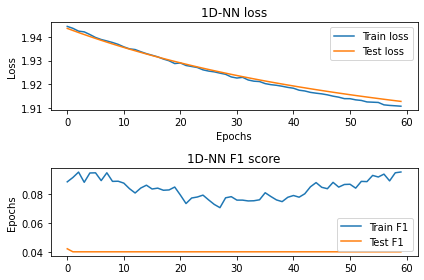

In [44]:
train_loss = history['train_loss']
train_f1 = history['train_f1']
test_loss = history['test_loss']
test_f1 = history['test_f1']

fig, axs = plt.subplots(2, 1)

axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epochs')
axs[0].plot(train_loss, label = 'Train loss')
axs[0].plot(test_loss, label = 'Test loss')
axs[0].legend()

axs[1].set_ylabel('F1 Score')
axs[1].set_ylabel('Epochs')
axs[1].plot(train_f1, label = 'Train F1')
axs[1].plot(test_f1, label = 'Test F1')
axs[1].legend()

axs[0].set_title('1D-NN loss')
axs[1].set_title('1D-NN F1 score')

fig.tight_layout()
fig.show()

In [25]:
eval = pd.read_csv('evaluation.csv')

signals = []
path = ""
samples = np.random.choice(len(eval), len(eval), replace = False)
for i in range(len(eval)):
    signal = None
    if i in samples:
        signal, sr = librosa.load(path + eval.loc[i]["filename"])
    signals.append(signal)
eval['signal'] = signals
eval = eval[eval['signal'].notnull()]
eval.head()

##-- TRIMMING AUDIO
eval['signal'] = eval['signal'].apply(lambda y: librosa.effects.trim(y, top_db=20)[0])
eval['signal'] = eval['signal'].apply(lambda y: librosa.effects.trim(y, top_db=20)[0])

##-- GENERATING SPECTROGRAM
spec_width = 224
eval['spec'] = eval['signal'].apply(lambda y: librosa.feature.melspectrogram(y = y, hop_length = math.floor(len(y)/spec_width), n_mels=spec_width))
eval['spec'] = eval['spec'].apply(lambda y: librosa.amplitude_to_db(y))
eval['spec'] = eval['spec'].apply(lambda y: np.delete(y, np.s_[spec_width:y.shape[1]], 1))

In [26]:
##-- AVERAGING THE SPECTROGRAM
eval['spec_avg'] = eval['spec'].apply(lambda y: np.average(y, axis=1))

##-- ENCODING ARRAY AND STANDARD SCALER
scaler = StandardScaler()
eval_matrix = scaler.fit_transform(np.stack(eval['spec_avg'].to_numpy(), axis = 0))

prediction = gs_clf.predict(eval_matrix)

In [27]:
sub = eval
sub['Id'] = eval['filename']
sub['Predicted'] = [tags[pred] for pred in prediction]
sub2 = sub.drop(sub.columns[[0,1,2,3]], axis=1)
sub2.to_csv('0predicted.csv', index=False)